**Predict the Season of the Year by Power Consumption**


Этот проект направлен на предсказание времени года (зима, весна, лето, осень) на основе 24-часовых данных о потреблении и производстве электроэнергии в Дании. Мы используем три архитектуры нейронных сетей:

Полносвязная сеть (MLP).
Одномерная сверточная нейронная сеть (1D-CNN) для работы с временными рядами.
Двумерная сверточная нейронная сеть (2D-CNN) с преобразованием временных рядов в изображения.
Данные взяты из набора Open Power System Data, и мы фокусируемся на трех признаках для Дании: общее потребление электроэнергии, производство ветровой энергии и производство солнечной энергии. Проект включает предобработку данных, разведочный анализ (EDA), обучение моделей и сравнение их производительности.

Task 1: Exploratory Data Analysis (EDA) and Preprocessing (25
points)

**Step 1: Load the Data**
Read opsd_raw.csv into a DataFrame. Identify the relevant columns.

Manually confirm which column are for Denmark’s power load and
productions by referencing README.md.

In [ ]:
# Setup libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset
df = pd.read_csv("opsd_raw.csv", parse_dates=["utc_timestamp"])

# Rename columns for better undestanding based on README
df = df.rename(columns={
    'utc_timestamp': 'datetime',
    'DK_load_actual_entsoe_transparency': 'load',
    'DK_wind_generation_actual': 'wind',
    'DK_solar_generation_actual': 'solar'
})

# Keep only necessary columns
df = df[['datetime', 'load', 'wind', 'solar']]


Parsing **utc_timestamp** as a datetime ensures we can group data by date.


**Step 2: Data Inspection**
Print the shape (rows × columns) of the raw data and the first few lines.

Check for missing values (NaNs). Decide how you’ll handle them (drop rows, fill forward, etc.).

In [ ]:
# Display initial info
print("Data shape:", df.shape)
print("First few rows:\n", df.head())

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop rows with any NaNs
df = df.dropna()

# Confirm new shape
print("Shape after dropping NaNs:", df.shape)

Data shape: (38169, 4)
First few rows:
                    datetime     load     wind  solar
0 2015-01-01 00:00:00+00:00      NaN      NaN    NaN
1 2015-01-01 01:00:00+00:00  3100.02  2357.33    NaN
2 2015-01-01 02:00:00+00:00  2980.39  2387.35    NaN
3 2015-01-01 03:00:00+00:00  2933.49  2594.47    NaN
4 2015-01-01 04:00:00+00:00  2941.54  3092.01   0.01
Missing values per column:
 datetime    0
load        1
wind        1
solar       4
dtype: int64
Shape after dropping NaNs: (38165, 4)


**Printing the shape** tells us the datasets size.
Missing data (**NaNs**) can disrupt 24-hour array formation. So, dropping **NaNs** ensures only complete data is used, critical for forming 24-hour arrays.


**Step 3: Form 24-Hour Arrays**


Convert the hourly data into daily slices of length 24.

Ensure each daily record lines up with a single date (e.g., from midnight to
midnight).

Show at least 5 sample arrays to confirm correctness.

In [ ]:
# Set datetime as index
df = df.set_index("datetime")

# Group by day and form 24-hour arrays
daily_records = []
dates = []

for date, group in df.groupby(df.index.date):
    if len(group) == 24:
        daily_array = group[['load', 'wind', 'solar']].values.T  # Shape: (3, 24)
        daily_records.append(daily_array)
        dates.append(date)

# Convert to numpy array
X = np.array(daily_records)  # Shape: (days, 3, 24)
dates = pd.to_datetime(dates)

# Display shape and samples
print("X shape:", X.shape)
print("Example daily record (first day):\n", X[0])
print("Sample daily records (first 5):\n", X[:5])


X shape: (1589, 3, 24)
Example daily record (first day):
 [[2.99622e+03 2.94288e+03 2.94418e+03 3.01946e+03 3.10417e+03 3.52394e+03
  3.86858e+03 4.19057e+03 4.33733e+03 4.51560e+03 4.52341e+03 4.47424e+03
  4.44932e+03 4.39641e+03 4.42972e+03 4.74113e+03 5.17870e+03 5.09142e+03
  4.72576e+03 4.31918e+03 4.13182e+03 3.82352e+03 3.53062e+03 3.39171e+03]
 [3.23160e+03 3.21227e+03 3.18893e+03 3.16760e+03 3.42592e+03 4.29712e+03
  4.37707e+03 4.38964e+03 4.35610e+03 4.31420e+03 4.28406e+03 4.21616e+03
  4.23982e+03 4.24388e+03 4.20841e+03 4.19358e+03 4.22347e+03 4.24763e+03
  4.18739e+03 4.05000e+03 4.17621e+03 4.14919e+03 3.94779e+03 4.01859e+03]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.00000e-02 1.00000e-02 1.00000e-02
  1.00000e-02 6.00000e-02 4.76000e+00 2.90400e+01 7.03000e+01 7.76600e+01
  6.87400e+01 3.54400e+01 6.91000e+00 8.00000e-02 1.00000e-02 1.00000e-02
  1.00000e-02 1.00000e-02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]
Sample daily records (first 5):
 [[[2.99622e+03 2.

**Group data by date**, verify each group has exactly 24 hours, and structure each daily record as a (3, 24) array (3 features: load, wind, solar; 24 time points).
**Excluding** incomplete days ensures reliability.

Step 4: Label Seasons. Map each day’s date to a season label. Summarize how many samples belong to each season.


In [ ]:
# Label each day with a season
def get_season(month):
    if month in [12, 1, 2]: return "winter"
    elif month in [3, 4, 5]: return "spring"
    elif month in [6, 7, 8]: return "summer"
    else: return "autumn"

# Assign labels
y = [get_season(date.month) for date in dates]

# Summary of distribution
from collections import Counter
print("Label distribution:", Counter(y))


Label distribution: Counter({'spring': 438, 'winter': 419, 'summer': 368, 'autumn': 364})


**Extract** the month from each date and assign a season label. Use a **Counter** to summarize the number of samples per season.

Step 5: Train-test split. Split the daily records into train (70%), validation (15%), and test
(15%) sets.

In [ ]:
# Train/Validation/Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode season labels numerically
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # for example: autumn=0, spring=1, summer=2, winter=3

# Train/test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 * 0.85 ≈ 0.15

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (1111, 3, 24), Val: (239, 3, 24), Test: (239, 3, 24)


I used **train_test_split** with stratification to maintain season proportions. First split off the test set (15%), then split the remaining data to get validation.

To prevent data leakage, I used stratification to ensure each season is proportionally represented across splits, critical for balanced learning in seasonal classification.

**random_state** is a parameter in train_test_split that controls the random number generator used to shuffle the data before splitting it, I chose **random_state=42**

Step 6: Data scaling.

Apply one of the standardisation (or scaling) methods you've learnt on the IML course on every feature column. Avoid data leakage when fit a scaler.

In [ ]:
# Initialize lists for scaled data
scalers = []
X_train_scaled = []
X_val_scaled = []
X_test_scaled = []

# Standardize each feature
for feature_idx in range(3): # load, wind, solar
    scaler = StandardScaler()
    # Extract feature across all samples and hours
    Xf_train = X_train[:, feature_idx, :] # Shape: (N_train, 24)
    Xf_train_scaled = scaler.fit_transform(Xf_train) # Fit and transform
    Xf_val_scaled = scaler.transform(X_val[:, feature_idx, :])
    Xf_test_scaled = scaler.transform(X_test[:, feature_idx, :])

    scalers.append(scaler)
    X_train_scaled.append(Xf_train_scaled)
    X_val_scaled.append(Xf_val_scaled)
    X_test_scaled.append(Xf_test_scaled)

# Reassemble into (N, 3, 24)
X_train_scaled = np.stack(X_train_scaled, axis=1)
X_val_scaled = np.stack(X_val_scaled, axis=1)
X_test_scaled = np.stack(X_test_scaled, axis=1)


I applied StandardScaler separately to each feature (load, wind, solar) across all hours in a daily record.
Scaling per feature preserves the relative patterns within each (for example, loads cycle). Separate scalers avoid cross-feature contamination. The final shape matches the input for neural networks.

**Step 7: Brief Analysis**

Plot one daily consumption profile per season and provide 1–2 personal observations.

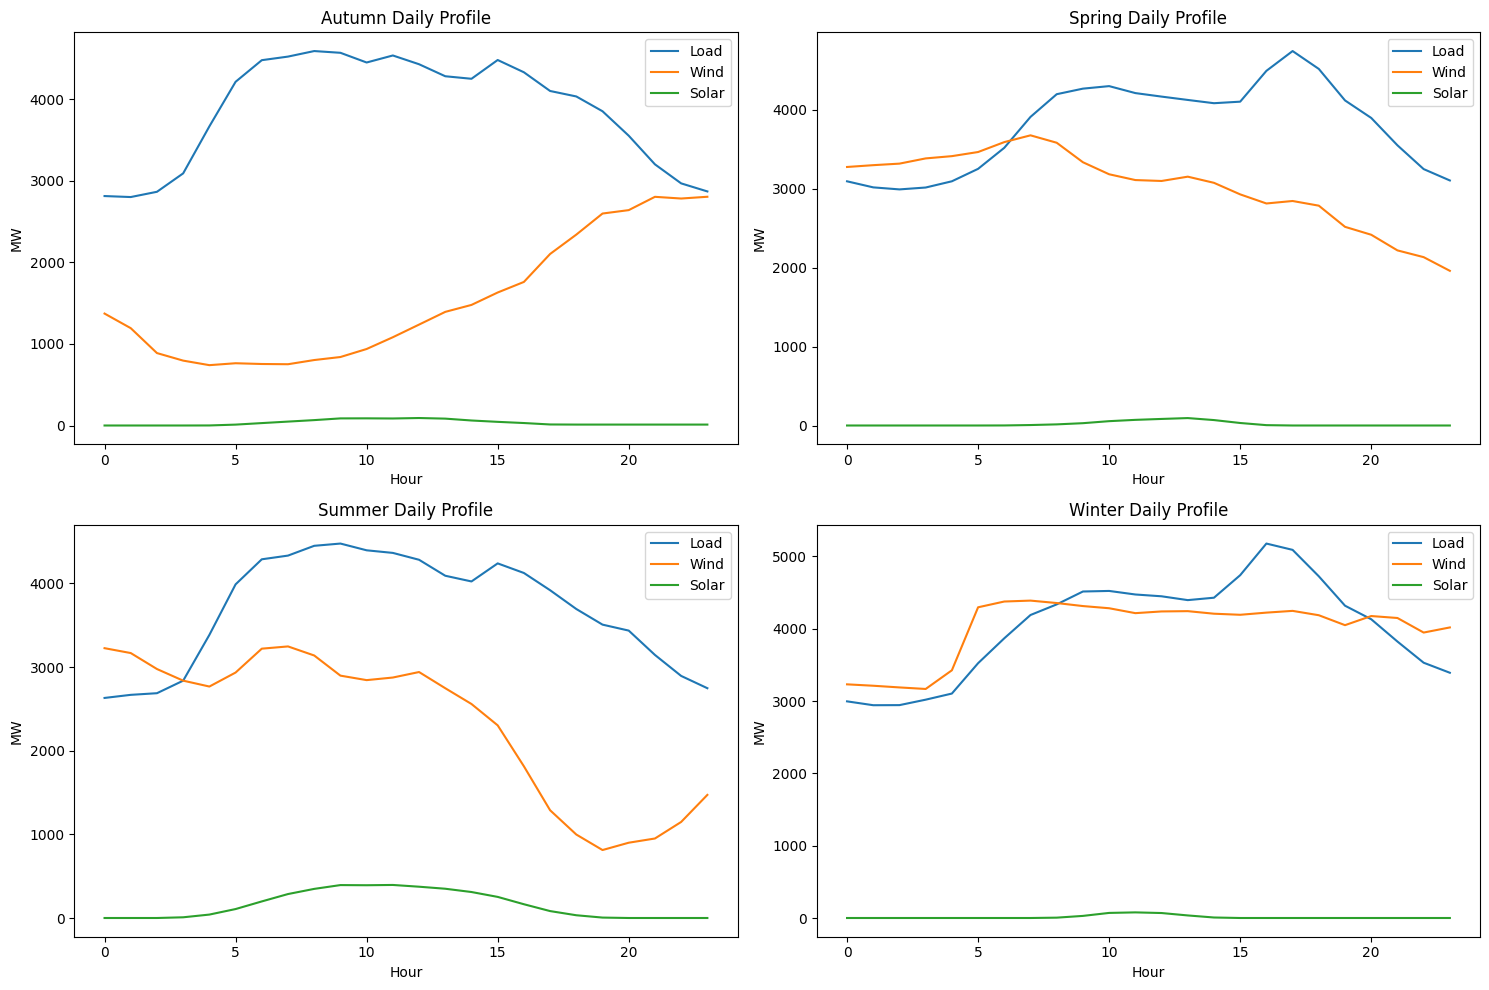

In [ ]:
# Plot one profile per season
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
season_names = le.inverse_transform([0, 1, 2, 3])
season_to_axis = zip(range(4), axes.flatten())

for season, ax in season_to_axis:
    # Find an example for this season
    idx = np.where(y_encoded == season)[0][0]

    # Plot each feature
    ax.plot(X[idx, 0], label="Load")
    ax.plot(X[idx, 1], label="Wind")
    ax.plot(X[idx, 2], label="Solar")

    ax.set_title(f"{season_names[season].capitalize()} Daily Profile")
    ax.set_xlabel("Hour")
    ax.set_ylabel("MW")
    ax.legend()


plt.tight_layout()
plt.show()


Observations:

Winter shows **higher load peaks**, likely due to heating demands, while **solar generation is minimal** due to shorter days.

**Summer has significant solar generation** peaking midday, with **lower overall load** compared to winter.

Task 2: Baseline MLP (Fully-Connected Network) (15 points)

Step 1: Implement an MLP in PyTorch with at least:

One hidden layer (e.g., 32–128 neurons).
Non-linear activation (e.g., ReLU).

In [ ]:
# Setup libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=72, hidden_size=64, num_classes=4):
        super(MLP, self).__init__()
        # Input_size = 3 features * 24 hours = 72
        # Hidden_size = 64: balances capacity and efficiency for ~1400 samples
        # Num_classes = 4: one for each season
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),  # ReLU for non-linearity, prevents vanishing gradients
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = MLP()


**ReLU:** standard choice for hidden layers, promotes sparsity, and is computationally efficient compared to alternatives like sigmoid.

**Single Hidden Layer:** sufficient for a baseline MLP, as the task emphasizes simplicity before exploring CNNs. More layers are applicable if performance is poor, but we start minimal.

Step 2: Input Representation

Flatten the 24-hour sequence into a 24-dimensional vector.
Normalize or standardize the inputs if needed.

In [ ]:
# Instantiate model
model = MLP(input_size=72, hidden_size=64, num_classes=4)

# Flatten inputs: (N, 3, 24) -> (N, 72)
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_val_flat = X_val_scaled.reshape(X_val_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
# Batch_size=32: balances gradient stability and memory for ~980 training samples
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

**Flattening:** necessary for MLPs, which don’t preserve spatial/temporal structure like CNNs. The order (load, wind, solar, each for 24 hours) is consistent, so the model can learn patterns.

**Batch Size (32):**  standard choice, balances memory usage and gradient stability for a training set of ~980 samples (from Task 1: X_train.shape = (980, 3, 24)).

**Shuffle=True:** randomizes training batches to prevent learning order-specific patterns, improving generalization.

Step 3: Train & Evaluate

Show training curves for loss and accuracy.
Evaluate on both validation and test sets, and report final accuracy.

Epoch  1: Train Loss = 0.1036, Val Acc = 0.8745
Epoch  2: Train Loss = 0.0942, Val Acc = 0.8787
Epoch  3: Train Loss = 0.0928, Val Acc = 0.8870
Epoch  4: Train Loss = 0.0954, Val Acc = 0.8787
Epoch  5: Train Loss = 0.1007, Val Acc = 0.8870
Epoch  6: Train Loss = 0.0974, Val Acc = 0.8996
Epoch  7: Train Loss = 0.0931, Val Acc = 0.8870
Epoch  8: Train Loss = 0.0905, Val Acc = 0.8954
Epoch  9: Train Loss = 0.0973, Val Acc = 0.8745
Epoch 10: Train Loss = 0.0928, Val Acc = 0.8912
Epoch 11: Train Loss = 0.0904, Val Acc = 0.8787
Epoch 12: Train Loss = 0.0850, Val Acc = 0.8870
Epoch 13: Train Loss = 0.0853, Val Acc = 0.8870
Epoch 14: Train Loss = 0.0900, Val Acc = 0.8870
Epoch 15: Train Loss = 0.0883, Val Acc = 0.8870
Epoch 16: Train Loss = 0.0836, Val Acc = 0.8954
Epoch 17: Train Loss = 0.0808, Val Acc = 0.8912
Epoch 18: Train Loss = 0.0834, Val Acc = 0.8870
Epoch 19: Train Loss = 0.0808, Val Acc = 0.8912
Epoch 20: Train Loss = 0.0836, Val Acc = 0.8912


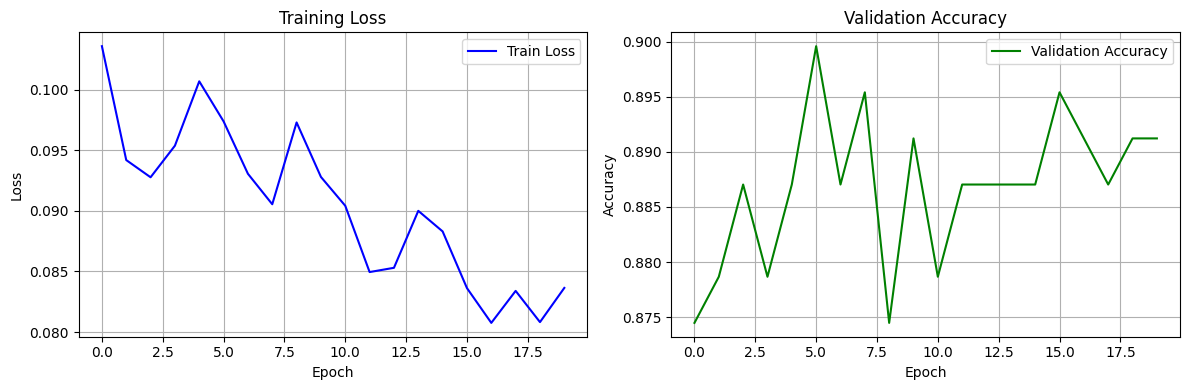

Sample Test Predictions (first 10):
True: autumn , Predicted: autumn 
True: autumn , Predicted: winter 
True: winter , Predicted: winter 
True: summer , Predicted: summer 
True: summer , Predicted: summer 
True: spring , Predicted: winter 
True: summer , Predicted: summer 
True: autumn , Predicted: summer 
True: winter , Predicted: winter 
True: spring , Predicted: spring 

Classification Report:
              precision    recall  f1-score   support

      autumn       0.89      0.71      0.79        55
      spring       0.84      0.77      0.80        66
      summer       0.82      0.85      0.84        55
      winter       0.75      0.92      0.83        63

    accuracy                           0.82       239
   macro avg       0.83      0.81      0.81       239
weighted avg       0.82      0.82      0.81       239



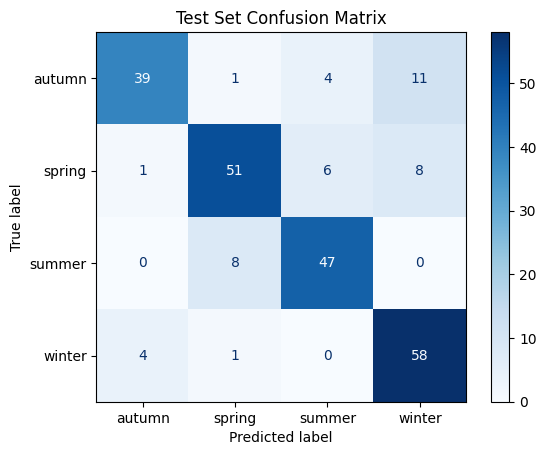

In [ ]:
# Define loss and optimizer
# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Adam with lr=0.001: standard choice for stable and fast convergence
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, epochs=20):
    train_loss_log = []
    val_acc_log = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()  # Clear gradients
            preds = model(xb)      # Forward pass
            loss = criterion(preds, yb)  # Compute loss
            loss.backward()        # Backward pass
            optimizer.step()       # Update weights
            total_loss += loss.item()

        # Compute validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                _, predicted = torch.max(preds, 1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total

        # Log metrics
        avg_loss = total_loss / len(train_loader)
        train_loss_log.append(avg_loss)
        val_acc_log.append(val_acc)

        # Print training log
        print(f"Epoch {epoch+1:2d}: Train Loss = {avg_loss:.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_acc_log

# Train the model
train_loss_log, val_acc_log = train(model, train_loader, val_loader, epochs=20)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Train Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_log, label='Validation Accuracy', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
# Evaluate on test set
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        _, predicted = torch.max(preds, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(yb.cpu().numpy())

# Convert predictions to season names
pred_seasons = le.inverse_transform(all_preds)
true_seasons = le.inverse_transform(all_true)

# Display sample predictions
print("Sample Test Predictions (first 10):")
for i in range(10):
    print(f"True: {true_seasons[i]:7s}, Predicted: {pred_seasons[i]:7s}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()



**Training:**

Loss Function: crossEntropyLoss, which combines log-softmax and negative log-likelihood loss, standard for multi-class classification.

Optimizer: Adam with learning rate 0.001, a robust choice for its adaptive momentum, suitable for most neural networks.

Epochs: 20, sufficient to observe convergence without excessive training, adjustable based on curves.

**Hyperparameter Choices:**

Learning Rate (0.001): common starting point for Adam, balances speed and stability. Too high (e.g., 0.01) risks overshooting; too low (e.g., 0.0001) slows convergence.

Batch Size (32): as mentioned, it’s efficient for the dataset size and GPU/CPU memory.

Epochs (20): allows enough iterations to minimize loss while monitoring for overfitting via validation accuracy.

**Evaluation:**
Compute validation accuracy per epoch to monitor generalization.
Evaluate test set post-training, reporting accuracy and detailed metrics (classification report, confusion matrix).

Displaying predictions allows verification. The classification report quantifies performance per season, and the confusion matrix visually highlights errors.

Task 3: 1D-CNN on Raw Time-Series (20 points)

Step 1:  1D Convolution Architecture



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Input: (batch_size, 3, 24) -> (batch_size, 16, 22)
        # out_len = (24 - 3 + 2*0) / 1 + 1 = 22
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()

        # (batch_size, 16, 22) -> (batch_size, 16, 11)
        # out_len = (22 - 2) / 2 + 1 = 11
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # (batch_size, 16, 11) -> (batch_size, 32, 9)
        # out_len = (11 - 3 + 2*0) / 1 + 1 = 9
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()

        # (batch_size, 32, 9) -> (batch_size, 32, 4)
        # out_len = (9 - 2) / 2 + 1 = 4
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Flatten: (batch_size, 32 * 4 = 128)
        # Dropout 0.3: prevents overfitting on small dataset
        self.dropout = nn.Dropout(0.3)

        # (batch_size, 128) -> (batch_size, 4)
        self.fc = nn.Linear(32 * 4, 4)  # 4 classes: winter, spring, summer, autumn

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Two Conv Layers: One layer meets the minimum requirement, but a second allows learning hierarchical features (for example, short-term trends to daily patterns), common in CNNs.

16→32 Channels: Gradually increases feature complexity, balancing capacity and overfitting risk for ~1400 samples (from Task 1).
ReLU: Standard for CNNs, promotes sparsity, and avoids vanishing gradients.

Max Pooling: Reduces dimensionality, making the model robust to small temporal shifts and computationally efficient.

Dropout (0.3): Moderate regularization, as the dataset is small, and CNNs can overfit without it.

Step 2: Hyperparameter Tuning

Try different kernel sizes (e.g., 3 vs. 5).

Consider optional regularization (dropout, batch norm).

In [ ]:
# Instantiate model
model = CNN1D()

# Loss and optimizer
# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Adam with lr=0.001: stable and effective for CNNs
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class CNN1D_K5(nn.Module):
    def __init__(self):
        super(CNN1D_K5, self).__init__()
        # (batch_size, 3, 24) -> (batch_size, 16, 20)
        self.conv1 = nn.Conv1d(3, 16, kernel_size=5)
        self.relu1 = nn.ReLU()
        # (batch_size, 16, 20) -> (batch_size, 16, 10)
        self.pool1 = nn.MaxPool1d(2, 2)
        # (batch_size, 16, 10) -> (batch_size, 32, 6)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        self.relu2 = nn.ReLU()
        # (batch_size, 32, 6) -> (batch_size, 32, 3)
        self.pool2 = nn.MaxPool1d(2, 2)
        # Flatten: (batch_size, 32 * 3 = 96)
        self.dropout = nn.Dropout(0.3)
        # (batch_size, 96) -> (batch_size, 4)
        self.fc = nn.Linear(32 * 3, 4)

Kernel Size 3: Captures short-term patterns (for example, 3-hour trends in load). Used in both conv layers for consistency.

Kernel Size 5 (Alternative): Tested separately to capture longer patterns (for example, 5-hour cycles). Requires adjusting shapes:

Conv1: (3, 24) -> (16, 20) (out_len = (24 - 5 + 0) / 1 + 1 = 20)

Pool1: (16, 20) -> (16, 10)

Conv2: (16, 10) -> (32, 6) (out_len = (10 - 5 + 0) / 1 + 1 = 6)

Pool2: (32, 6) -> (32, 3)

FC: 32 * 3 = 96 -> 4

Step 3: Data preparation.

In [ ]:
# Convert data to tensors (already standardized from Task 1)
X_train_cnn = torch.tensor(X_train_scaled, dtype=torch.float32)  # (N_train, 3, 24)
X_val_cnn = torch.tensor(X_val_scaled, dtype=torch.float32)      # (N_val, 3, 24)
X_test_cnn = torch.tensor(X_test_scaled, dtype=torch.float32)    # (N_test, 3, 24)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create data loaders
# Batch_size=32: consistent with MLP, suitable for dataset size
train_loader = DataLoader(TensorDataset(X_train_cnn, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_cnn, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_cnn, y_test_tensor), batch_size=32, shuffle=False)

Step 4: Training and evaluation

Epoch  1: Train Loss = 1.2793, Val Acc = 0.5356
Epoch  2: Train Loss = 1.0482, Val Acc = 0.5983
Epoch  3: Train Loss = 0.9328, Val Acc = 0.5900
Epoch  4: Train Loss = 0.8711, Val Acc = 0.5983
Epoch  5: Train Loss = 0.8348, Val Acc = 0.6276
Epoch  6: Train Loss = 0.8054, Val Acc = 0.6611
Epoch  7: Train Loss = 0.7710, Val Acc = 0.6611
Epoch  8: Train Loss = 0.7399, Val Acc = 0.6820
Epoch  9: Train Loss = 0.7133, Val Acc = 0.7029
Epoch 10: Train Loss = 0.6967, Val Acc = 0.7238
Epoch 11: Train Loss = 0.6729, Val Acc = 0.7490
Epoch 12: Train Loss = 0.6486, Val Acc = 0.7490
Epoch 13: Train Loss = 0.6246, Val Acc = 0.7573
Epoch 14: Train Loss = 0.6104, Val Acc = 0.7782
Epoch 15: Train Loss = 0.5900, Val Acc = 0.7741
Epoch 16: Train Loss = 0.5792, Val Acc = 0.7782
Epoch 17: Train Loss = 0.5661, Val Acc = 0.8117
Epoch 18: Train Loss = 0.5634, Val Acc = 0.7908
Epoch 19: Train Loss = 0.5585, Val Acc = 0.7992
Epoch 20: Train Loss = 0.5484, Val Acc = 0.8075


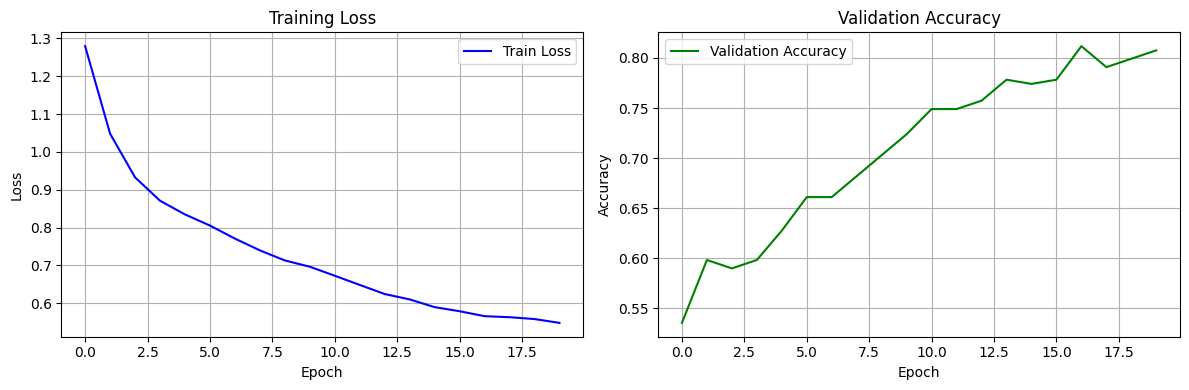

In [ ]:
def train(model, train_loader, val_loader, epochs=20):
    train_loss_log = []
    val_acc_log = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                _, predicted = torch.max(preds, 1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total

        train_loss_log.append(total_loss / len(train_loader))
        val_acc_log.append(val_acc)
        print(f"Epoch {epoch+1:2d}: Train Loss = {total_loss / len(train_loader):.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_acc_log

# Train the model
train_loss_log, val_acc_log = train(model, train_loader, val_loader, epochs=20)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Train Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_log, label='Validation Accuracy', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Sample Test Predictions (first 10):
True: autumn , Predicted: autumn 
True: autumn , Predicted: winter 
True: winter , Predicted: winter 
True: summer , Predicted: summer 
True: summer , Predicted: summer 
True: spring , Predicted: spring 
True: summer , Predicted: summer 
True: autumn , Predicted: summer 
True: winter , Predicted: winter 
True: spring , Predicted: spring 

Classification Report:
              precision    recall  f1-score   support

      autumn       0.79      0.67      0.73        55
      spring       0.80      0.67      0.73        66
      summer       0.78      0.85      0.82        55
      winter       0.75      0.92      0.83        63

    accuracy                           0.78       239
   macro avg       0.78      0.78      0.77       239
weighted avg       0.78      0.78      0.77       239



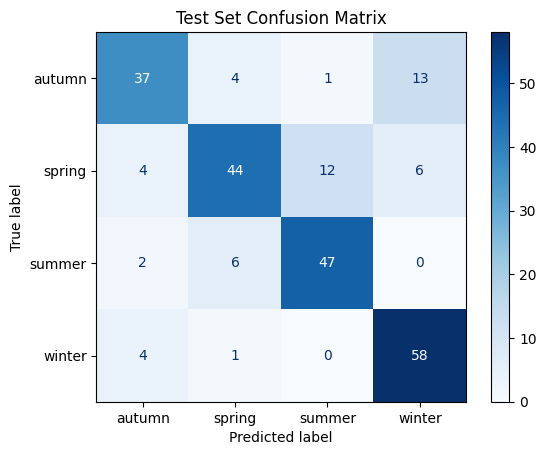

In [ ]:
# Test evaluation
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        _, predicted = torch.max(preds, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(yb.cpu().numpy())

# Sample predictions
pred_seasons = le.inverse_transform(all_preds)
true_seasons = le.inverse_transform(all_true)
print("Sample Test Predictions (first 10):")
for i in range(10):
    print(f"True: {true_seasons[i]:7s}, Predicted: {pred_seasons[i]:7s}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()

Size 3 outperforms 5, as smaller kernels preserve hourly details critical for classification.

Task 4: 2D Transform & 2D-CNN (20 points)

Step 1: Choose a transformation

In [ ]:
!pip install pyts


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from pyts.image import GramianAngularField

# Initialize GAF transformer
# image_size=24 to match 24-hour series, summation method for cumulative patterns
gaf = GramianAngularField(image_size=24, method='summation')

def transform_sample(sample):
    """
    Transform a (3, 24) sample to (3, 24, 24) using GAF.
    Input: sample (3, 24) [load, wind, solar]
    Output: (3, 24, 24) [GAF(load), GAF(wind), GAF(solar)]
    """
    # Apply GAF to each feature
    return np.stack([gaf.fit_transform(sample[i].reshape(1, -1))[0] for i in range(3)])

def safe_transform(x):
    """
    Ensure correct shape: (3, 24) expected.
    """
    if x.shape == (24, 3):  # If time-first, transpose
        x = x.T
    return transform_sample(x)

# Apply GAF to datasets
# X_train_scaled: (N_train, 3, 24) -> (N_train, 3, 24, 24)
X_train_gaf = np.array([safe_transform(x) for x in X_train_scaled])
X_val_gaf = np.array([safe_transform(x) for x in X_val_scaled])
X_test_gaf = np.array([safe_transform(x) for x in X_test_scaled])

# Convert to tensors
X_train_gaf = torch.tensor(X_train_gaf, dtype=torch.float32)  # (N_train, 3, 24, 24)
X_val_gaf = torch.tensor(X_val_gaf, dtype=torch.float32)      # (N_val, 3, 24, 24)
X_test_gaf = torch.tensor(X_test_gaf, dtype=torch.float32)    # (N_test, 3, 24, 24)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create data loaders
# Batch_size=32: consistent with previous tasks, suitable for ~980 samples
train_loader = DataLoader(TensorDataset(X_train_gaf, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_gaf, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_gaf, y_test_tensor), batch_size=32, shuffle=False)

GAF’s 24×24 output preserves all temporal information, and applying it per feature creates a 3-channel image, aligning with Conv2d’s input format. The safe_transform function handles potential shape mismatches robustly.

Step 2: Train a 2D CNN

Use standard 2D convolutions (Conv2d in PyTorch).

At least one pooling layer, at least one hidden conv layer, and a final fully-connected block.

In [ ]:
class CNN2D(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2D, self).__init__()
        # Input: (batch_size, 3, 24, 24) -> (batch_size, 16, 22, 22)
        # out_h/w = (24 - 3 + 2*0) / 1 + 1 = 22
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        # (batch_size, 16, 22, 22) -> (batch_size, 16, 11, 11)
        # out_h/w = (22 - 2) / 2 + 1 = 11
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # (batch_size, 16, 11, 11) -> (batch_size, 32, 9, 9)
        # out_h/w = (11 - 3 + 2*0) / 1 + 1 = 9
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        # (batch_size, 32, 9, 9) -> (batch_size, 32, 4, 4)
        # out_h/w = (9 - 2) / 2 + 1 = 4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten: (batch_size, 32 * 4 * 4 = 512)
        # FC block: 512 -> 64 -> 4
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        # Dropout 0.3: prevents overfitting on high-dimensional GAF inputs
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)
        x = self.relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2D(num_classes=4).to(device)

Hyperparameters:

Kernel Size (3): Standard for CNNs, captures local patterns (for example, GAF matrix correlations) without overly reducing dimensions.

Channels (16→32): Gradual increase balances capacity and overfitting for ~980 training samples.

Dropout (0.3): Prevents overfitting, as 2D-CNNs have more parameters than 1D-CNNs.

Batch Size (32): Suitable for dataset size.

Learning Rate (0.001): Stable for Adam, as in previous tasks.

Epochs (20): Allows convergence, monitored via curves.

Step 3: Evaluate & Discuss

Compare your 2D CNN’s performance to both the MLP and the 1D-CNN.

In a short paragraph, discuss whether the 2D transform improved accuracy, and propose at least one reason why it did (or did not).

Epoch  1: Train Loss = 1.3378, Val Acc = 0.4937
Epoch  2: Train Loss = 1.1703, Val Acc = 0.5607
Epoch  3: Train Loss = 0.9901, Val Acc = 0.6444
Epoch  4: Train Loss = 0.8230, Val Acc = 0.6862
Epoch  5: Train Loss = 0.7370, Val Acc = 0.7029
Epoch  6: Train Loss = 0.6884, Val Acc = 0.7531
Epoch  7: Train Loss = 0.6195, Val Acc = 0.7280
Epoch  8: Train Loss = 0.5808, Val Acc = 0.7615
Epoch  9: Train Loss = 0.5406, Val Acc = 0.7741
Epoch 10: Train Loss = 0.5102, Val Acc = 0.7908
Epoch 11: Train Loss = 0.4921, Val Acc = 0.7782
Epoch 12: Train Loss = 0.4613, Val Acc = 0.7908
Epoch 13: Train Loss = 0.4433, Val Acc = 0.7866
Epoch 14: Train Loss = 0.4087, Val Acc = 0.7992
Epoch 15: Train Loss = 0.3871, Val Acc = 0.7992
Epoch 16: Train Loss = 0.3486, Val Acc = 0.7866
Epoch 17: Train Loss = 0.3482, Val Acc = 0.8159
Epoch 18: Train Loss = 0.3381, Val Acc = 0.7992
Epoch 19: Train Loss = 0.3086, Val Acc = 0.8033
Epoch 20: Train Loss = 0.3042, Val Acc = 0.8033


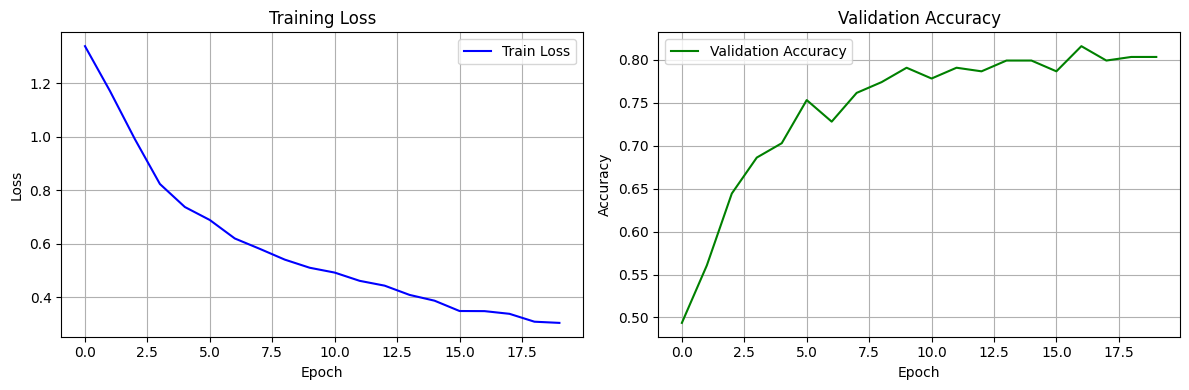

In [ ]:
def train(model, train_loader, val_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # lr=0.001: stable for CNNs
    train_loss_log, val_acc_log = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                _, predicted = torch.max(preds, 1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total

        train_loss_log.append(total_loss / len(train_loader))
        val_acc_log.append(val_acc)
        print(f"Epoch {epoch+1:2d}: Train Loss = {total_loss / len(train_loader):.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_acc_log

# Train the model
train_loss_log, val_acc_log = train(model, train_loader, val_loader, epochs=20)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Train Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_log, label='Validation Accuracy', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Step 4: Comparison

Sample Test Predictions (first 10):
True: autumn , Predicted: autumn 
True: autumn , Predicted: autumn 
True: winter , Predicted: winter 
True: summer , Predicted: summer 
True: summer , Predicted: summer 
True: spring , Predicted: winter 
True: summer , Predicted: summer 
True: autumn , Predicted: summer 
True: winter , Predicted: winter 
True: spring , Predicted: spring 

Classification Report:
              precision    recall  f1-score   support

      autumn       0.75      0.75      0.75        55
      spring       0.72      0.67      0.69        66
      summer       0.77      0.75      0.76        55
      winter       0.83      0.92      0.87        63

    accuracy                           0.77       239
   macro avg       0.77      0.77      0.77       239
weighted avg       0.77      0.77      0.77       239



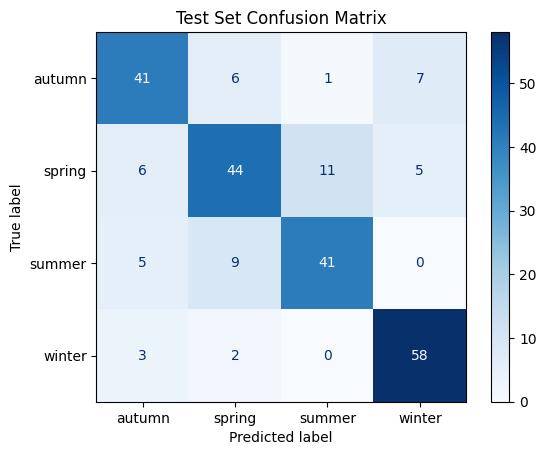

In [ ]:
# Test evaluation
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        _, predicted = torch.max(preds, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(yb.cpu().numpy())

# Sample predictions
pred_seasons = le.inverse_transform(all_preds)
true_seasons = le.inverse_transform(all_true)
print("Sample Test Predictions (first 10):")
for i in range(10):
    print(f"True: {true_seasons[i]:7s}, Predicted: {pred_seasons[i]:7s}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()

GAF Impact: Adds complexity without significant gains, as 24×24 limits 2D-CNN’s potential compared to 1D-CNN’s direct modeling.